In [18]:
import psycopg2
import pandas as pd
import numpy as np
import os
import copy
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit import DataStructs

from mordred import Calculator, descriptors, Lipinski
import mordred

import mlflow
from mlflow.models.signature import infer_signature
from mlflow.utils.environment import _mlflow_conda_env

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import f1_score, confusion_matrix, average_precision_score, roc_auc_score, recall_score, \
precision_score, accuracy_score, precision_recall_curve
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import KFold
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion, Pipeline, make_pipeline
from sklearn.decomposition import PCA

from xgboost import XGBClassifier, plot_importance
from sklearn.linear_model import BayesianRidge, LinearRegression, LogisticRegression, RidgeClassifier, RidgeClassifierCV

import logging

from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import logging 
import pickle
import json

from IPython.display import IFrame

import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_columns', None)
random_seed = 42

%config Completer.use_jedi = False

logging.basicConfig(stream=sys.stdout)
logger = logging.getLogger(name=__name__)
logger.setLevel(logging.DEBUG)

In [2]:
logger.info(os.environ['CONDA_DEFAULT_ENV'])
logger.info(os.getcwd())

INFO:__main__:rorgammaqsar
INFO:__main__:/home/rafalb/work/molecules/moleculeGenerator/moleculegenerator/moleculegenerator/notebooks/activity_prediction/activity_prediction_app_devel/notebook


# Helper functions

In [3]:
def get_levels(x):
    y = x.dropna()
    if y.empty:
        return np.nan
    else:
        levs = list(set(y.tolist()))
        if len(levs) == 1:
            return levs[0]
        else:
            return 'mix'

def get_all_levels(x):
    y = x.dropna()
    if y.empty:
        return np.nan
    else:
        return sorted(list(set(y.tolist())))
                
def get_mean(x):
    y = x.dropna()
    if y.empty:
        return np.nan
    else:
        return np.mean(y)
    
def initialize_seeds(random_seed):
    np.random.seed(random_seed)
    tf.random.set_seed(random_seed)
    rn.seed(random_seed)
    
def set_up_mlflow(experiment):
    server_ip = "10.210.200.190"
    os.environ['AWS_ACCESS_KEY_ID'] = 'mlflow'
    os.environ['AWS_SECRET_ACCESS_KEY'] = 'uSPmPqTZv4YQh8M7oMqq'
    os.environ['MLFLOW_S3_ENDPOINT_URL'] = f"http://{server_ip}:9000"
    mlflow.set_tracking_uri(f"http://{server_ip}:9002")
    mlflow.set_experiment(experiment)
    
def connect2DB(user = 'chembl', password='chembl', host='127.0.0.1', port='16001', database='chembl_28'):
    connection = psycopg2.connect(user = user,
                    password = password,
                    host = host,
                    port = port,
                    database = database)
    return connection

# Database connection

In [4]:
con = connect2DB()
cursor = con.cursor()
cursor.execute("select * from target_dictionary as tardi \
where tardi.pref_name like '%ROR%'")

In [5]:
logger.info("list of ROR-like receptors in the ChEMBL database...")
pd.DataFrame(cursor.fetchall())

INFO:__main__:list of ROR-like receptors in the ChEMBL database...


,0,1,2,3,4,5,6
0,101591,SINGLE PROTEIN,Nuclear receptor ROR-alpha,9606,Homo sapiens,CHEMBL5868,0
1,103664,SINGLE PROTEIN,Nuclear receptor ROR-gamma,10090,Mus musculus,CHEMBL1293231,0
2,103982,SINGLE PROTEIN,Nuclear receptor ROR-gamma,9606,Homo sapiens,CHEMBL1741186,0
3,105356,SINGLE PROTEIN,Tyrosine-protein kinase transmembrane receptor...,10090,Mus musculus,CHEMBL2176781,0
4,107581,SINGLE PROTEIN,Tyrosine-protein kinase transmembrane receptor...,9606,Homo sapiens,CHEMBL2375201,0
5,107979,SINGLE PROTEIN,Nuclear receptor ROR-beta,9606,Homo sapiens,CHEMBL3091268,0
6,108261,SINGLE PROTEIN,Nuclear receptor ROR-alpha,10090,Mus musculus,CHEMBL3217403,0
7,117326,SINGLE PROTEIN,Nuclear receptor ROR-beta,10116,Rattus norvegicus,CHEMBL4105721,0


In [6]:
#cursor = con.cursor()
#cursor.execute("select * from ( \
#select * from activities as act \
#inner join assays as assays on act.assay_id=assays.assay_id inner join target_dictionary as tardi on assays.tid=tardi.tid \
#inner join compound_structures as cs on act.molregno=cs.molregno \
#where tardi.pref_name like '%ROR%') as combined")

* RORgamma - homo sapiens

In [7]:
def create_query(receptor):
    query = "select * from ( \
    select * from activities as act \
    inner join assays as assays on act.assay_id=assays.assay_id \
    left join docs as docs on act.doc_id=docs.doc_id \
    join target_dictionary as tardi on assays.tid=tardi.tid \
    inner join compound_structures as cs on act.molregno=cs.molregno \
    inner join compound_properties as cp on act.molregno=cp.molregno \
    left join molecule_dictionary as md on act.molregno=md.molregno \
    left join ligand_eff as le on act.activity_id=le.activity_id \
    where tardi.chembl_id in ('"+receptor+"')) as combined"
    return query

In [8]:
# ROR gamma homo sapiens
rorgamma_homo_sapiens_receptor = "CHEMBL1741186"
# ROR gamma mus musculus
rorgamma_mus_musculus_receptor = "CHEMBL1293231"

query = create_query(rorgamma_homo_sapiens_receptor)
cursor = con.cursor()
cursor.execute(query)

data = pd.DataFrame(cursor.fetchall())
colnames = [desc[0] for desc in cursor.description]
data.columns = colnames

con.close()

In [9]:
data.head()

,activity_id,assay_id,doc_id,record_id,molregno,standard_relation,standard_value,standard_units,standard_flag,standard_type,activity_comment,data_validity_comment,potential_duplicate,pchembl_value,bao_endpoint,uo_units,qudt_units,toid,upper_value,standard_upper_value,src_id,type,relation,value,units,text_value,standard_text_value,assay_id,doc_id,description,assay_type,assay_test_type,assay_category,assay_organism,assay_tax_id,assay_strain,assay_tissue,assay_cell_type,assay_subcellular_fraction,tid,relationship_type,confidence_score,curated_by,src_id,src_assay_id,chembl_id,cell_id,bao_format,tissue_id,variant_id,aidx,doc_id,journal,year,volume,issue,first_page,last_page,pubmed_id,doi,chembl_id,title,doc_type,authors,abstract,patent_id,ridx,src_id,tid,target_type,pref_name,tax_id,organism,chembl_id,species_group_flag,molregno,molfile,standard_inchi,standard_inchi_key,canonical_smiles,molregno,mw_freebase,alogp,hba,hbd,psa,rtb,ro3_pass,num_ro5_violations,cx_most_apka,cx_most_bpka,cx_logp,cx_logd,molecular_species,full_mwt,aromatic_rings,heavy_atoms,qed_weighted,mw_monoisotopic,full_molformula,hba_lipinski,hbd_lipinski,num_lipinski_ro5_violations,molregno,pref_name,chembl_id,max_phase,therapeutic_flag,dosed_ingredient,structure_type,chebi_par_id,molecule_type,first_approval,oral,parenteral,topical,black_box_warning,natural_product,first_in_class,chirality,prodrug,inorganic_flag,usan_year,availability_type,usan_stem,polymer_flag,usan_substem,usan_stem_definition,indication_class,withdrawn_flag,withdrawn_year,withdrawn_country,withdrawn_reason,withdrawn_class,activity_id,bei,sei,le,lle
0,11456733,845157,51887,1710289,1409150,None,220.0,nM,1,IC50,probe,None,0,None,BAO_0000190,UO_0000065,http://www.openphacts.org/units/Nanomolar,None,None,None,7,IC50,None,0.22,uM,None,None,845157,51887,PubChem BioAssay. Late stage assay provider co...,F,None,confirmatory,Homo sapiens,9606.0,None,None,None,None,103982,D,9,Autocuration,7,624276,CHEMBL2114768,NaN,BAO_0000019,NaN,None,CLD0,51887,None,NaN,None,None,None,None,NaN,None,CHEMBL1201862,PubChem BioAssay data set,DATASET,None,None,None,CLD0,7,103982,SINGLE PROTEIN,Nuclear receptor ROR-gamma,9606,Homo sapiens,CHEMBL1741186,0,1409150,\n RDKit 2D\n\n 37 40 0 0 0 0...,"InChI=1S/C26H24F7N3O/c27-23-15-21(24(37,25(28,...",KVHKWAZUPPBMLL-UHFFFAOYSA-N,OC(c1ccc(-c2ccc(CN3CCN(Cc4ccncc4)CC3)cc2)c(F)c...,1409150,527.48,5.52,4.0,1.0,39.60,6.0,N,2.0,7.17,7.83,4.27,4.40,NEUTRAL,527.48,3.0,37.0,0.43,527.1808,C26H24F7N3O,4.0,1.0,2.0,1409150,None,CHEMBL2137199,0,0,0,MOL,NaN,Small molecule,NaN,0,0,0,0,-1,-1,-1,-1,-1,NaN,-1.0,None,0,None,None,None,0,NaN,None,None,None,NaN,None,None,None,None
1,5980337,737070,51887,1381757,1092851,=,2080.0,nM,1,IC50,Active,None,0,5.68,BAO_0000190,UO_0000065,http://www.openphacts.org/units/Nanomolar,None,None,None,7,IC50,=,2.08,um,None,None,737070,51887,PUBCHEM_BIOASSAY: Late stage results from the ...,U,None,screening,None,NaN,None,None,None,None,103982,H,8,Autocuration,7,2117_2,CHEMBL1738628,NaN,BAO_0000019,NaN,None,CLD0,51887,None,NaN,None,None,None,None,NaN,None,CHEMBL1201862,PubChem BioAssay data set,DATASET,None,None,None,CLD0,7,103982,SINGLE PROTEIN,Nuclear receptor ROR-gamma,9606,Homo sapiens,CHEMBL1741186,0,1092851,\n RDKit 2D\n\n 30 32 0 0 0 0...,InChI=1S/C15H8ClF6N3O4S/c16-9-5-6-10(12-11(9)2...,DVUUFKVQAGWFAF-UHFFFAOYSA-N,O=S(=O)(Nc1ccc(C(O)(C(F)(F)F)C(F)(F)F)cc1)c1cc...,1092851,475.75,3.99,6.0,2.0,105.32,4.0,N,0.0,6.56,None,3.54,2.63,NEUTRAL,475.75,3.0,30.0,0.55,474.9828,C15H8ClF6N3O4S,7.0,2.0,0.0,1092851,None,CHEMBL1712120,0,0,0,MOL,NaN,Small molecule,NaN,0,0,0,0,-1,-1,-1,-1,-1,NaN,-1.0,None,0,None,None,None,0,NaN,None,None,None,NaN,None,None,None,None
2,5980338,737070,51887,1381756,1099175,>,20000.0,nM,1,IC50,inactive,None,0,None,BAO_0000190,UO_0000065,http://www.openphacts.org/units/Nanomolar,None,None,None,7,IC50,>,20.0,um,None,None,737070,51887,PUBCHEM_BIOASSAY: Late stage results from the ...,U,None,screening,None,NaN,None,None,None,None,103982,H,8,Autocuration,7,2117

* rename the chembl_id columns 

In [10]:
chembl_idx = [item[0] for item in enumerate(data.columns) if item[1].startswith('chembl_id')]
chembl_idx_labels = ['chembl_id_assay', 'chembl_id_doc', 'chembl_id_target', 'chembl_id_compound']

In [11]:
chembl_idx

[45, 60, 73, 105]

In [12]:
tmp = data.columns.tolist()
for i,idx in enumerate(chembl_idx):
    tmp[idx] = chembl_idx_labels[i]
data.columns = tmp

In [13]:
data.head()

,activity_id,assay_id,doc_id,record_id,molregno,standard_relation,standard_value,standard_units,standard_flag,standard_type,activity_comment,data_validity_comment,potential_duplicate,pchembl_value,bao_endpoint,uo_units,qudt_units,toid,upper_value,standard_upper_value,src_id,type,relation,value,units,text_value,standard_text_value,assay_id,doc_id,description,assay_type,assay_test_type,assay_category,assay_organism,assay_tax_id,assay_strain,assay_tissue,assay_cell_type,assay_subcellular_fraction,tid,relationship_type,confidence_score,curated_by,src_id,src_assay_id,chembl_id_assay,cell_id,bao_format,tissue_id,variant_id,aidx,doc_id,journal,year,volume,issue,first_page,last_page,pubmed_id,doi,chembl_id_doc,title,doc_type,authors,abstract,patent_id,ridx,src_id,tid,target_type,pref_name,tax_id,organism,chembl_id_target,species_group_flag,molregno,molfile,standard_inchi,standard_inchi_key,canonical_smiles,molregno,mw_freebase,alogp,hba,hbd,psa,rtb,ro3_pass,num_ro5_violations,cx_most_apka,cx_most_bpka,cx_logp,cx_logd,molecular_species,full_mwt,aromatic_rings,heavy_atoms,qed_weighted,mw_monoisotopic,full_molformula,hba_lipinski,hbd_lipinski,num_lipinski_ro5_violations,molregno,pref_name,chembl_id_compound,max_phase,therapeutic_flag,dosed_ingredient,structure_type,chebi_par_id,molecule_type,first_approval,oral,parenteral,topical,black_box_warning,natural_product,first_in_class,chirality,prodrug,inorganic_flag,usan_year,availability_type,usan_stem,polymer_flag,usan_substem,usan_stem_definition,indication_class,withdrawn_flag,withdrawn_year,withdrawn_country,withdrawn_reason,withdrawn_class,activity_id,bei,sei,le,lle
0,11456733,845157,51887,1710289,1409150,None,220.0,nM,1,IC50,probe,None,0,None,BAO_0000190,UO_0000065,http://www.openphacts.org/units/Nanomolar,None,None,None,7,IC50,None,0.22,uM,None,None,845157,51887,PubChem BioAssay. Late stage assay provider co...,F,None,confirmatory,Homo sapiens,9606.0,None,None,None,None,103982,D,9,Autocuration,7,624276,CHEMBL2114768,NaN,BAO_0000019,NaN,None,CLD0,51887,None,NaN,None,None,None,None,NaN,None,CHEMBL1201862,PubChem BioAssay data set,DATASET,None,None,None,CLD0,7,103982,SINGLE PROTEIN,Nuclear receptor ROR-gamma,9606,Homo sapiens,CHEMBL1741186,0,1409150,\n RDKit 2D\n\n 37 40 0 0 0 0...,"InChI=1S/C26H24F7N3O/c27-23-15-21(24(37,25(28,...",KVHKWAZUPPBMLL-UHFFFAOYSA-N,OC(c1ccc(-c2ccc(CN3CCN(Cc4ccncc4)CC3)cc2)c(F)c...,1409150,527.48,5.52,4.0,1.0,39.60,6.0,N,2.0,7.17,7.83,4.27,4.40,NEUTRAL,527.48,3.0,37.0,0.43,527.1808,C26H24F7N3O,4.0,1.0,2.0,1409150,None,CHEMBL2137199,0,0,0,MOL,NaN,Small molecule,NaN,0,0,0,0,-1,-1,-1,-1,-1,NaN,-1.0,None,0,None,None,None,0,NaN,None,None,None,NaN,None,None,None,None
1,5980337,737070,51887,1381757,1092851,=,2080.0,nM,1,IC50,Active,None,0,5.68,BAO_0000190,UO_0000065,http://www.openphacts.org/units/Nanomolar,None,None,None,7,IC50,=,2.08,um,None,None,737070,51887,PUBCHEM_BIOASSAY: Late stage results from the ...,U,None,screening,None,NaN,None,None,None,None,103982,H,8,Autocuration,7,2117_2,CHEMBL1738628,NaN,BAO_0000019,NaN,None,CLD0,51887,None,NaN,None,None,None,None,NaN,None,CHEMBL1201862,PubChem BioAssay data set,DATASET,None,None,None,CLD0,7,103982,SINGLE PROTEIN,Nuclear receptor ROR-gamma,9606,Homo sapiens,CHEMBL1741186,0,1092851,\n RDKit 2D\n\n 30 32 0 0 0 0...,InChI=1S/C15H8ClF6N3O4S/c16-9-5-6-10(12-11(9)2...,DVUUFKVQAGWFAF-UHFFFAOYSA-N,O=S(=O)(Nc1ccc(C(O)(C(F)(F)F)C(F)(F)F)cc1)c1cc...,1092851,475.75,3.99,6.0,2.0,105.32,4.0,N,0.0,6.56,None,3.54,2.63,NEUTRAL,475.75,3.0,30.0,0.55,474.9828,C15H8ClF6N3O4S,7.0,2.0,0.0,1092851,None,CHEMBL1712120,0,0,0,MOL,NaN,Small molecule,NaN,0,0,0,0,-1,-1,-1,-1,-1,NaN,-1.0,None,0,None,None,None,0,NaN,None,None,None,NaN,None,None,None,None
2,5980338,737070,51887,1381756,1099175,>,20000.0,nM,1,IC50,inactive,None,0,None,BAO_0000190,UO_0000065,http://www.openphacts.org/units/Nanomolar,None,None,None,7,IC50,>,20.0,um,None,None,737070,51887,PUBCHEM_BIOASSAY: Late stage results from the ...,U,None,screening,None,NaN,None,None,None,None,1039

In [14]:
data.shape

(6054, 139)

* remove the duplicated columns 

In [15]:
data = data.T.drop_duplicates().T

<function matplotlib.pyplot.show(close=None, block=None)>

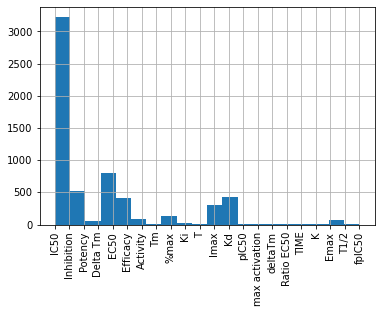

In [16]:
data['standard_type'].hist(bins=20)
plt.xticks(rotation='vertical')
plt.show

* remove tha rows for which the 'standard_value' and 'standard_units' is nan

In [17]:
data = data[~pd.isna(data['standard_value'])]
data = data[~pd.isna(data['standard_units'])]
data.shape

(5780, 123)

* take only the chosen type, e.g. the IC50 values

In [20]:
aggFunctions = {
    'standard_value': ['min', 'max', get_all_levels, get_mean],
    'standard_units': [get_levels, get_all_levels],
    'standard_type': get_levels,
    'activity_comment': get_levels,
    'type': get_levels,
    'chembl_id_compound': get_levels,
    'full_mwt': 'min',
    'canonical_smiles': get_levels
}

def expand_activity(x):
    expanded = [None for iii in range(max_level_activity)]
    n_act = len(x)
    expanded[:n_act] = x[:n_act]
    return np.array(expanded)

In [32]:
raw_types = data["standard_type"].unique().tolist()
clean_types = [item.replace(" ", "").replace("/", "").replace("%", "") for item in raw_types]

In [38]:
chosen_type = "IC50"
all_results = {} 
for chosen_type, clean_type in zip(raw_types, clean_types):
    data_slice = copy.deepcopy(data[data["standard_type"]==chosen_type])

    data_grouped = data_slice.groupby('molregno')
    data_aggregated = data_grouped.agg(aggFunctions)
    max_level_activity = max(data_aggregated[("standard_value", "get_all_levels")].apply(lambda x: len(x)))
    data_aggregated.columns = [str(item[0])+"_"+str(item[1]) for item in data_aggregated.columns.to_flat_index().to_list()]

    all_activities = data_aggregated[("standard_value_get_all_levels")].apply(lambda x: expand_activity(x))
    all_activities = pd.DataFrame(all_activities.to_list(), columns=["act_"+str(iii) for iii in range(max_level_activity)])
    all_activities = all_activities.set_index(data_aggregated.index)

    data_aggregated = pd.concat([data_aggregated, all_activities], axis=1)
    data_aggregated = data_aggregated.drop(["standard_value_get_all_levels", "standard_units_get_all_levels", "standard_value_min",
                                            "standard_value_max", "standard_value_max", "activity_comment_get_levels",
                                            "type_get_levels", "full_mwt_min"], axis=1)
    data_aggregated.to_csv("ror_gamma_homo_sapiens_"+clean_type+".csv", index=True)
    all_results[clean_type] = data_aggregated
    print(data_aggregated.shape)

(2220, 18)
(495, 7)
(178, 8)
(56, 6)
(624, 9)
(319, 9)
(1, 6)
(110, 8)
(16, 6)
(4, 6)
(30, 7)
(177, 9)
(287, 10)
(3, 6)
(2, 6)
(2, 7)
(42, 7)
(5, 6)


In [39]:
all_results["IC50"]

,standard_value_get_mean,standard_units_get_levels,standard_type_get_levels,chembl_id_compound_get_levels,canonical_smiles_get_levels,act_0,act_1,act_2,act_3,act_4,act_5,act_6,act_7,act_8,act_9,act_10,act_11,act_12
molregno,,,,,,,,,,,,,,,,,,
2208,199.530000,nM,IC50,CHEMBL38,CC1=C(/C=C/C(C)=C/C=C/C(C)=C/C(=O)O)C(C)(C)CCC1,199.53,None,None,None,None,None,None,None,None,None,None,None,None
40459,31900.000000,nM,IC50,CHEMBL28721,O=C(O)C(S)C(S)C(=O)O,31900.0,None,None,None,None,None,None,None,None,None,None,None,None
92776,1770.094667,nM,IC50,CHEMBL62136,O=S(=O)(c1ccccc1)N(CC(F)(F)F)c1ccc(C(O)(C(F)(F...,60.0,204.0,316.23,330.0,501.19,540.0,1700.0,1730.0,2010.0,3000.0,3500.0,4400.0,6500.0
155592,10000.000000,nM,IC50,CHEMBL418971,CC(C)(c1ccc(O)cc1)c1ccc(O)cc1,10000.0,None,None,None,None,None,None,None,None,None,None,None,None
201200,2820.000000,nM,IC50,CHEMBL169,C[C@@H]1[C@H]2C3=CC[C@@H]4[C@@]5(C)CC[C@H](O)C...,130.0,680.0,1060.0,9410.0,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2459160,75.000000,nM,IC50,CHEMBL4588729,O=C(O)c1ccc(-n2cc(C(=O)c3c(Cl)cccc3Cl)c3ccccc3...,75.0,None,None,None,None,None,None,None,None,None,None,None,None
2459686,2578.000000,nM,IC50,CHEMBL4589255,Cc1c(C(=O)c2c(Cl)cccc2Cl)c2ccccc2n1-c1ccc(C(=O...,156.0,5000.0,None,None,None,None,None,None,None,None,None,None,None
2462878,27.000000,nM,IC50,CHEMBL4592447,Cc1cccc(Cl)c1C(=O)c1cn(-c2ccc(C(=O)O)cc2F)c2nc...,27.0,None,None,None,None,None,None,None,None,None,None,None,None


<function matplotlib.pyplot.show(close=None, block=None)>

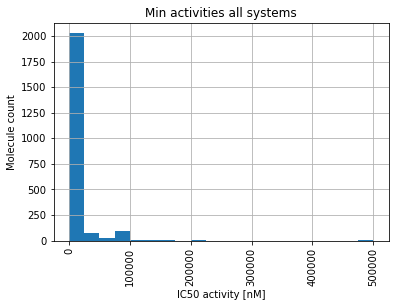

In [47]:
all_results["IC50"]["act_0"].hist(bins=20)
plt.xticks(rotation='vertical')
plt.title('Min activities all systems')
plt.xlabel('IC50 activity [nM]')
plt.ylabel('Molecule count')
plt.show

Text(0, 0.5, 'Molecule count')

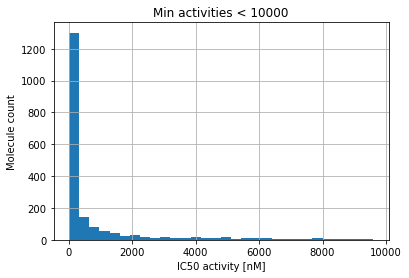

In [45]:
threshold = 10000
all_results["IC50"][all_results["IC50"]["act_0"] < threshold]["act_0"].hist(bins=30)
plt.title('Min activities < '+str(threshold))
plt.xlabel('IC50 activity [nM]')
plt.ylabel('Molecule count')